<a href="https://colab.research.google.com/github/asadali163/Time-Series-Experiments/blob/main/codebase/ML_(Sales_Data_Champange).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O champange.csv https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv

--2024-07-21 17:54:25--  https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1598 (1.6K) [text/csv]
Saving to: ‘champange.csv’

champange.csv       100%[===================>]   1.56K  --.-KB/s    in 0s      

2024-07-21 17:54:26 (16.6 MB/s) - ‘champange.csv’ saved [1598/1598]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score


In [ ]:
df = pd.read_csv('champange.csv', index_col='Month', parse_dates=True, skipfooter=2)
df.head()

<ipython-input-8-d572efc6f9c2>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('champange.csv', index_col='Month', parse_dates=True, skipfooter=2)


,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [ ]:
df.rename(columns={'Perrin Freres monthly champagne sales millions ?64-?72': 'Sales'}, inplace=True)
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [ ]:
df.isnull().sum()

Sales    0
dtype: int64

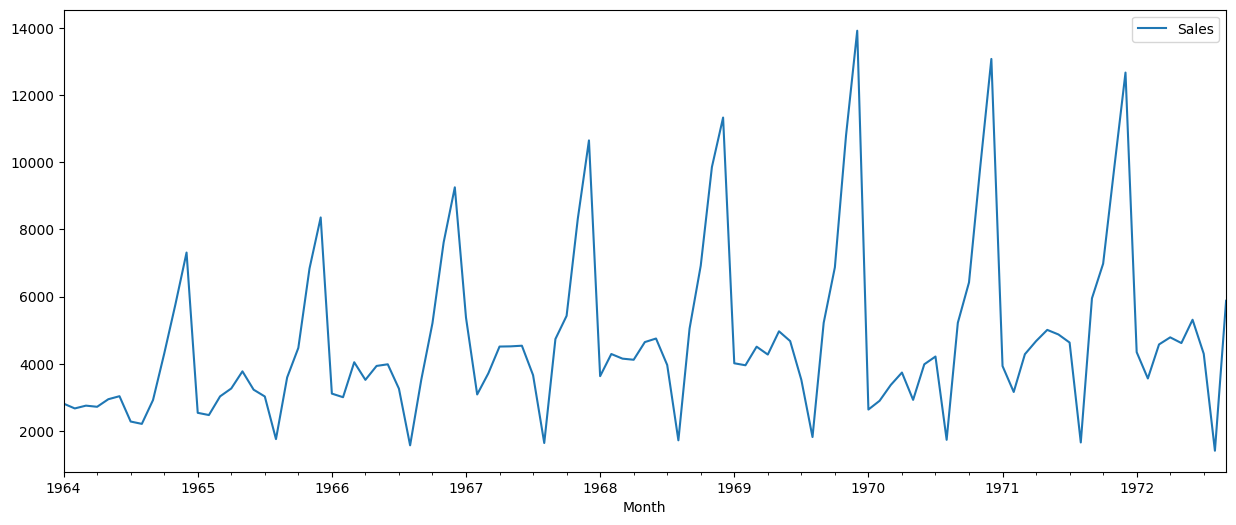

In [ ]:
df.plot(figsize=(15,6));

In [ ]:
df['LogSales'] = np.log(df['Sales'])
df.head()

,Sales,LogSales
Month,,
1964-01-01,2815,7.942718
1964-02-01,2672,7.890583
1964-03-01,2755,7.921173
1964-04-01,2721,7.908755
1964-05-01,2946,7.988204


In [ ]:
df['DiffLogSales'] = df['LogSales'].diff()
df.head()

,Sales,LogSales,DiffLogSales
Month,,,
1964-01-01,2815,7.942718,NaN
1964-02-01,2672,7.890583,-0.052135
1964-03-01,2755,7.921173,0.030590
1964-04-01,2721,7.908755,-0.012418
1964-05-01,2946,7.988204,0.079449


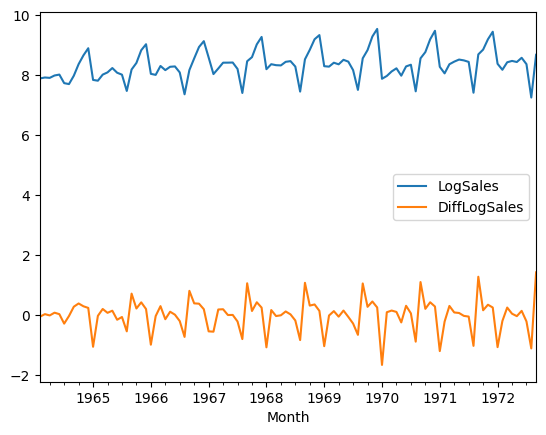

In [ ]:
df[['LogSales', 'DiffLogSales']][1:].plot();

As there is clearly trend and seasonality.<br>
So here we will try 3 things.
* 1 step forecast
* Multistep forecast
* Multistep multi output forecast

#### Let's do first 1 step forecast

In [ ]:
N_test = 12
train = df[:-N_test]
test = df[-N_test:]

In [ ]:
# We will use previous 12 lags, because of the seasonality of 12.
series = df['LogSales'].to_numpy()

T = 12
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X)
Y = np.array(Y)
print("X shape is : ", X.shape, " Y shape is : ", Y.shape)

X shape is :  (93, 12)  Y shape is :  (93,)


In [ ]:
X_train = X[:-N_test]
Y_train = Y[:-N_test]
X_test = X[-N_test:]
Y_test = Y[-N_test:]

print("X_train shape is : ", X_train.shape, " Y_train shape is : ", Y_train.shape)
print("X_test shape is : ", X_test.shape, " Y_test shape is : ", Y_test.shape)

X_train shape is :  (81, 12)  Y_train shape is :  (81,)
X_test shape is :  (12, 12)  Y_test shape is :  (12,)


In [ ]:
# Let's do prediction with linear regression first.
lr = LinearRegression()
lr.fit(X_train, Y_train)
lr.score(X_train, Y_train)

0.8682372095558999

In [ ]:
lr.score(X_test, Y_test)

0.9657520752272787

In [ ]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]
train_idx[:T] = False

In [ ]:
df.loc[train_idx, 'LR_1step_forecast_train'] = lr.predict(X_train)
df.loc[test_idx, 'LR_1step_forecast_test'] = lr.predict(X_test)


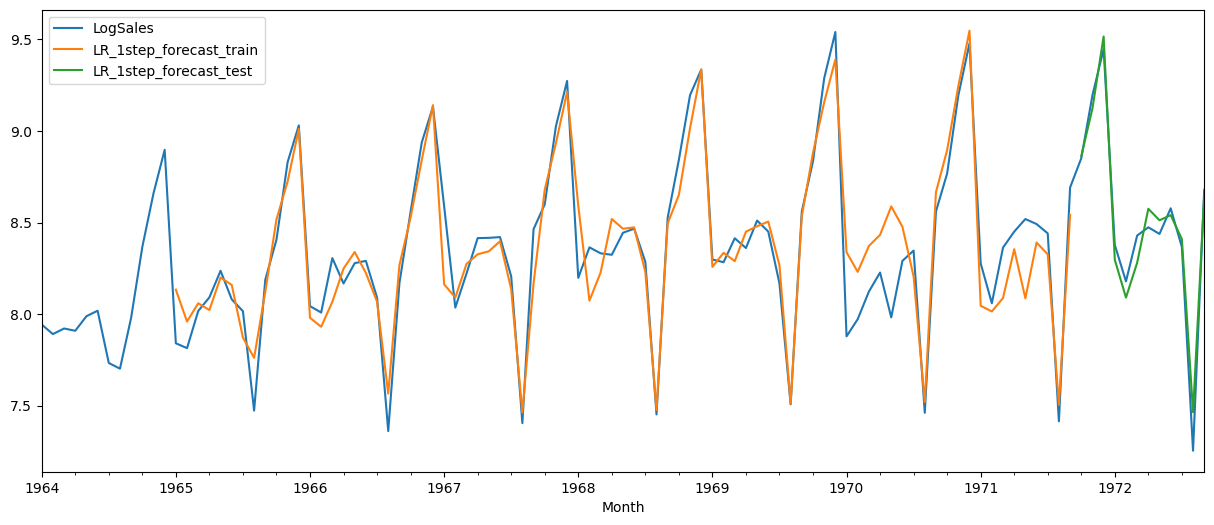

In [ ]:
df[['LogSales', 'LR_1step_forecast_train', 'LR_1step_forecast_test']].plot(figsize=(15,6));

#### Let's do now multi-step forecast

In [ ]:
last_x = X_test[0]
print(last_x.shape)
last_x

(12,)


array([8.76779626, 9.19441422, 9.47853377, 8.277412  , 8.05896002,
       8.36310918, 8.45019832, 8.51919119, 8.49167023, 8.44095989,
       7.41397029, 8.69131455])

(1, 12)

In [ ]:
multistep_prediction = []
last_x = X_test[0]
while len(multistep_prediction) < N_test:
  p = lr.predict(last_x.reshape(1, -1))[0]
  multistep_prediction.append(p)
  last_x = np.roll(last_x, -1)
  last_x[-1] = p


In [ ]:
df.loc[test_idx, 'LR_multistep_forecast'] = multistep_prediction

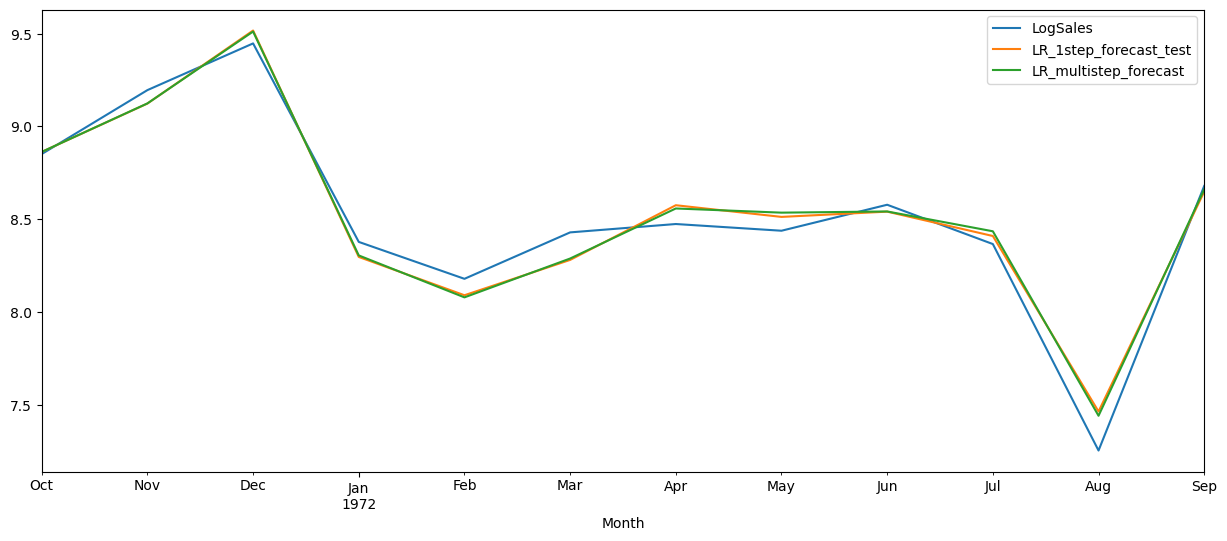

In [ ]:
# Let's plot them
df[['LogSales', 'LR_1step_forecast_test', 'LR_multistep_forecast']][-N_test:].plot(figsize=(15,6));

Both of them have a good score and a good prediction

#### Let's do now multi step multi output prediction

In [ ]:
Tx = T
Ty = N_test
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X)
Y = np.array(Y)
print("X shape is : ", X.shape, " Y shape is : ", Y.shape)


X shape is :  (82, 12)  Y shape is :  (82, 12)


In [ ]:
X_train_m, Y_train_m = X[:-1], Y[:-1]
X_test_m, Y_test_m = X[-1:], Y[-1:]

print(X_train_m.shape, Y_train_m.shape)
print(X_test_m.shape, Y_test_m.shape)

(81, 12) (81, 12)
(1, 12) (1, 12)


In [ ]:
lr = LinearRegression()
lr.fit(X_train_m, Y_train_m)
lr.score(X_train_m, Y_train_m)

0.8829262390390559

In [ ]:
lr.score(X_test_m, Y_test_m)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

In [ ]:
# As you can see that the score cannot be predicted for a single value.

r2_score(lr.predict(X_test_m).flatten(), Y_test_m.flatten())

0.9595107879158425

In [ ]:
df.loc[test_idx, 'LR_multistep_multioutput_forecast'] = lr.predict(X_test_m).flatten()

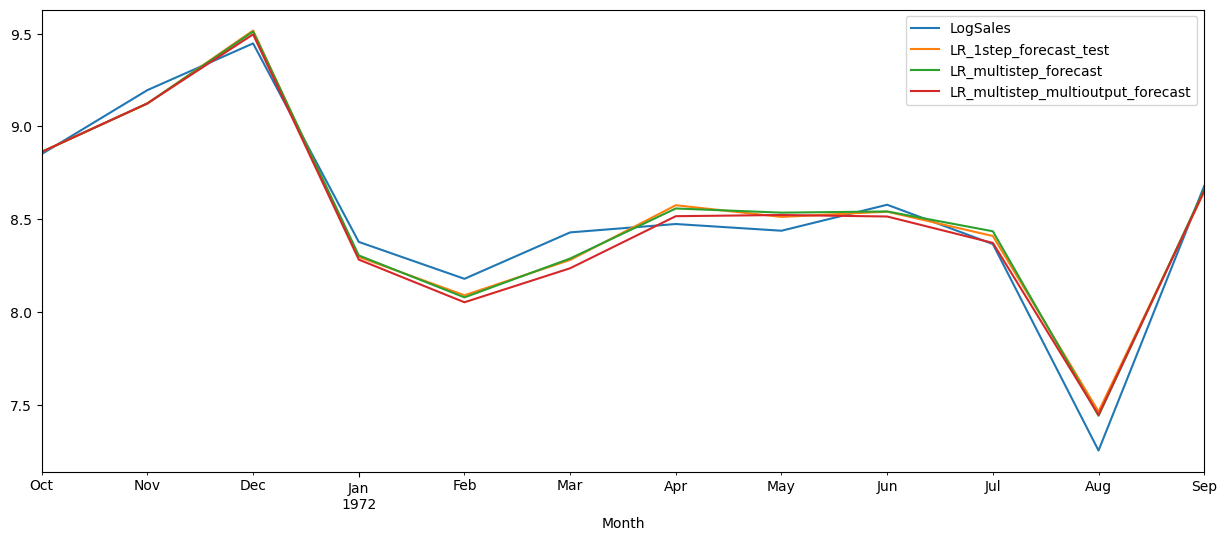

In [ ]:
# Let's plot it
df[['LogSales', 'LR_1step_forecast_test', 'LR_multistep_forecast', 'LR_multistep_multioutput_forecast']][-N_test:].plot(figsize=(15,6));

As all the graphs are closely related, let's check the mape of all of them.

In [ ]:
mape_1step = mean_absolute_percentage_error(df.loc[test_idx, 'LogSales'], df.loc[test_idx, 'LR_1step_forecast_test'])
mape_multistep = mean_absolute_percentage_error(df.loc[test_idx, 'LogSales'], df.loc[test_idx, 'LR_multistep_forecast'])
mape_multistep_multioutput = mean_absolute_percentage_error(df.loc[test_idx, 'LogSales'], df.loc[test_idx, 'LR_multistep_multioutput_forecast'])

print("1 step forecast: ", mape_1step)
print("Multistep forecast: ", mape_multistep)
print("Multistep multioutput forecast: ", mape_multistep_multioutput)

1 step forecast:  0.009784167557640831
Multistep forecast:  0.009607169373797667
Multistep multioutput forecast:  0.009727020853255903


So from this it is confirm that the multistep forecast is best one

#### Let's check some other models

In [ ]:
# Let's create method for 1 step and multistep forecast.
def onestep_and_multistep_forecast(model, name):
  """
  modle = The model we use
  name = Model name which is prepended for column name
  """
  model.fit(X_train, Y_train)

  df.loc[train_idx, f"{name}_1step_train"] = model.predict(X_train)
  df.loc[test_idx, f"{name}_1step_test"] = model.predict(X_test)

  multistep_prediction = []

  last_x = X_test[0]
  while len(multistep_prediction) < N_test:
    p = model.predict(last_x.reshape(1, -1))[0]

    multistep_prediction.append(p)
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

  df.loc[test_idx, f"{name}_multistep_test"] = multistep_prediction

  mape = mean_absolute_percentage_error(Y_test, multistep_prediction)
  print(f"{name} MAPE: ", mape)

  cols = ['LogSales', f"{name}_1step_train", f"{name}_1step_test", f"{name}_multistep_test"]
  df[cols].plot(figsize=(15,5));

SVR MAPE:  0.013188370472848127


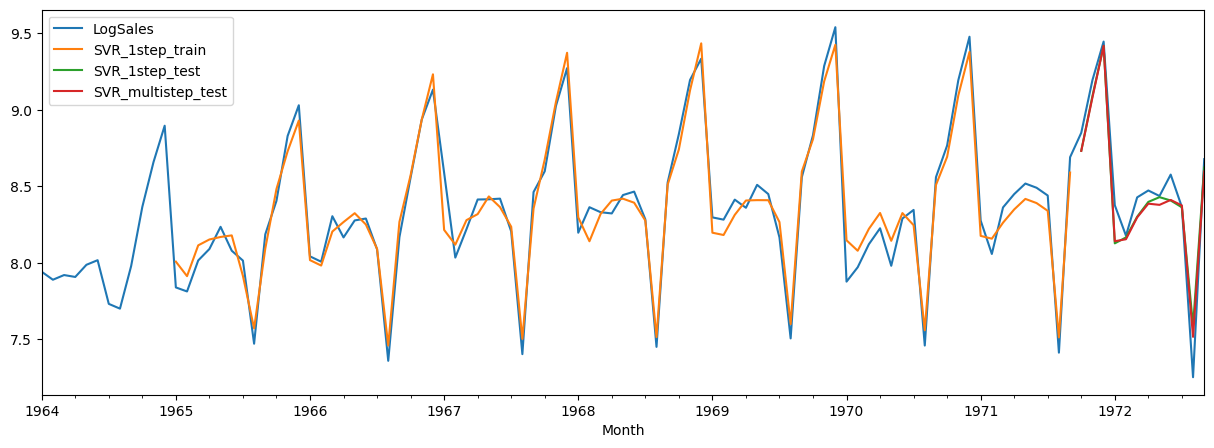

In [ ]:
# Let's check the SVR First
onestep_and_multistep_forecast(SVR(), "SVR")

RF MAPE:  0.010377987270752558


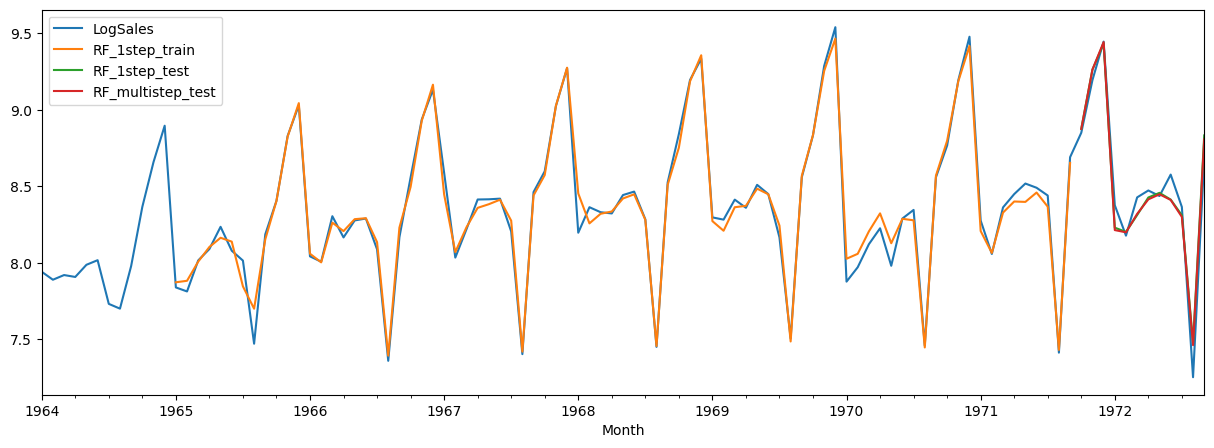

In [ ]:
onestep_and_multistep_forecast(RandomForestRegressor(), "RF")